# <b><u>  Forecasts for Product Demand

In [ ]:
!pip install seaborn xgboost lightgbm statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('../datasets/Historical_Product_Demand.csv')

In [3]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [4]:
df.shape

(1048575, 5)

In [5]:
df.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB



## <b>Exploratory Data Analysis (EDA)</b>

In [7]:
# 1. Handle missing values
print("Missing values before handling:")
print(df.isna().sum())

# Drop rows with missing dates (since time is crucial for forecasting)
df = df.dropna(subset=['Date'])
df['Date'] = pd.to_datetime(df['Date'])

Missing values before handling:
Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64


In [8]:
# 2. Clean Order_Demand column (remove parentheses and convert to numeric)
df['Order_Demand'] = df['Order_Demand'].str.replace('(', '').str.replace(')', '').astype(int)


In [9]:
# 3. Basic statistics
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
       Order_Demand
count  1.037336e+06
mean   4.949384e+03
std    2.907344e+04
min    0.000000e+00
25%    2.000000e+01
50%    3.000000e+02
75%    2.000000e+03
max    4.000000e+06


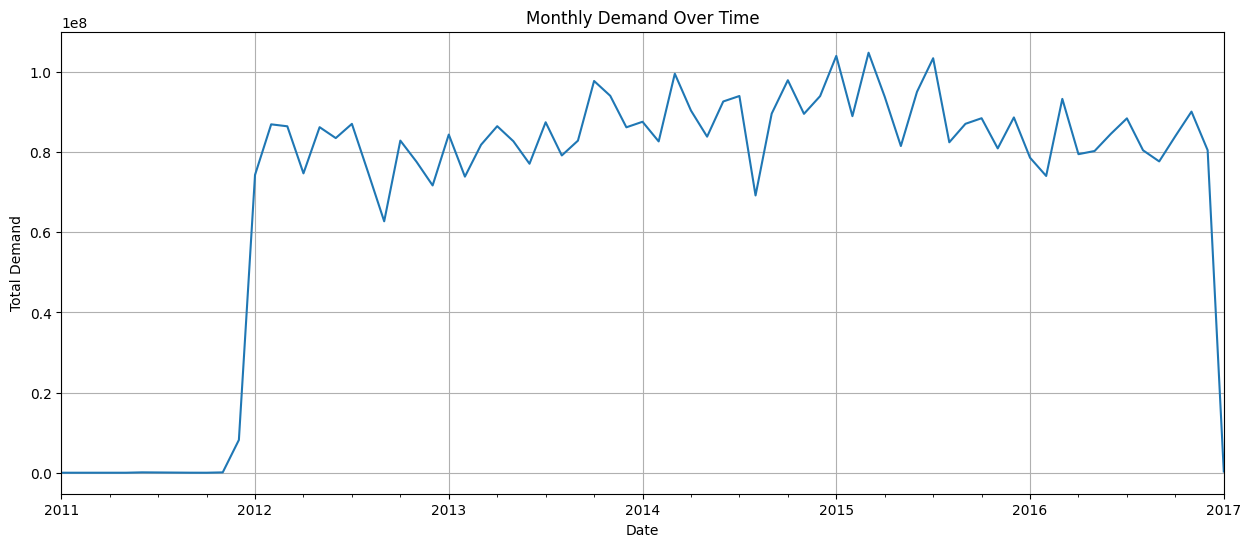

In [10]:
# 4. Temporal analysis
plt.figure(figsize=(15, 6))
df.groupby(df['Date'].dt.to_period('M'))['Order_Demand'].sum().plot()
plt.title('Monthly Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.grid()
plt.show()


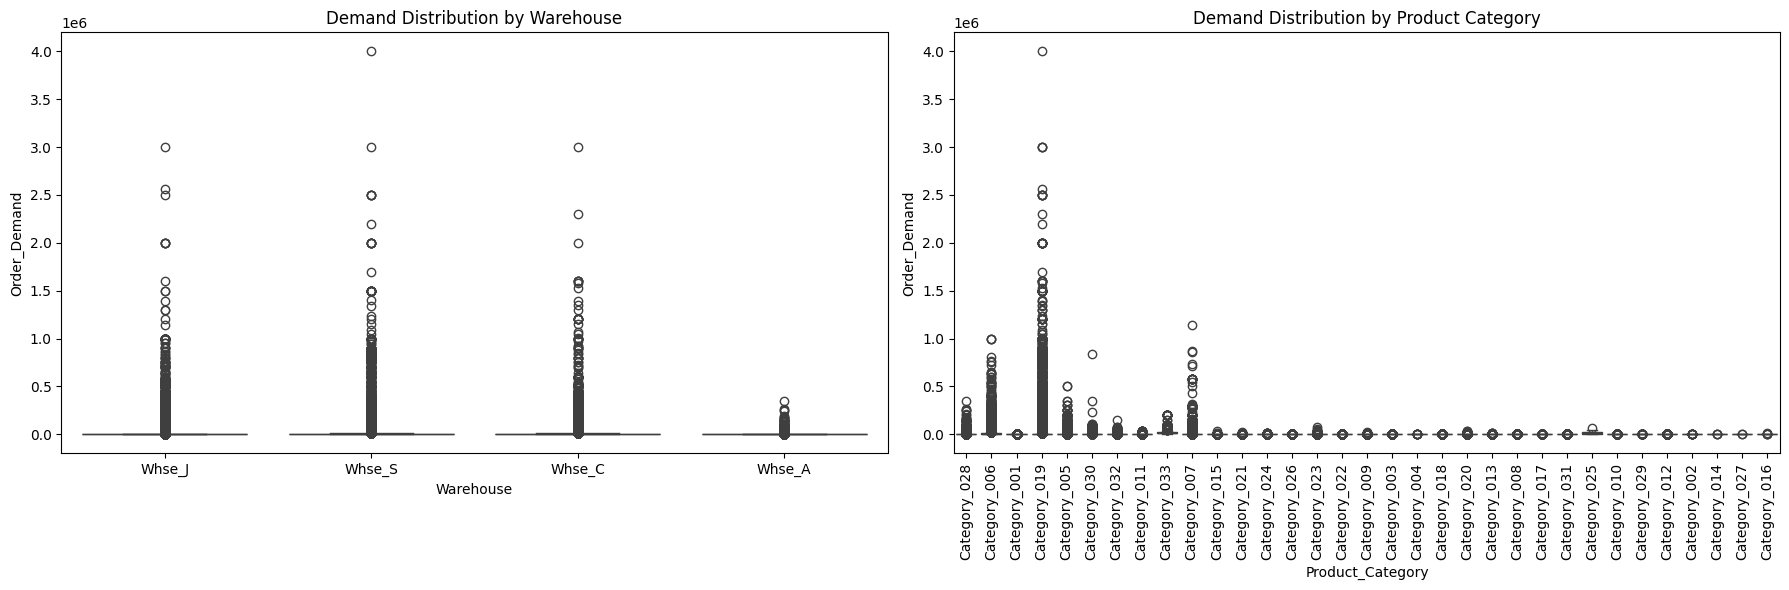

In [11]:
# 5. Warehouse and Category analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(data=df, x='Warehouse', y='Order_Demand', ax=axes[0])
axes[0].set_title('Demand Distribution by Warehouse')
sns.boxplot(data=df, x='Product_Category', y='Order_Demand', ax=axes[1])
axes[1].set_title('Demand Distribution by Product Category')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

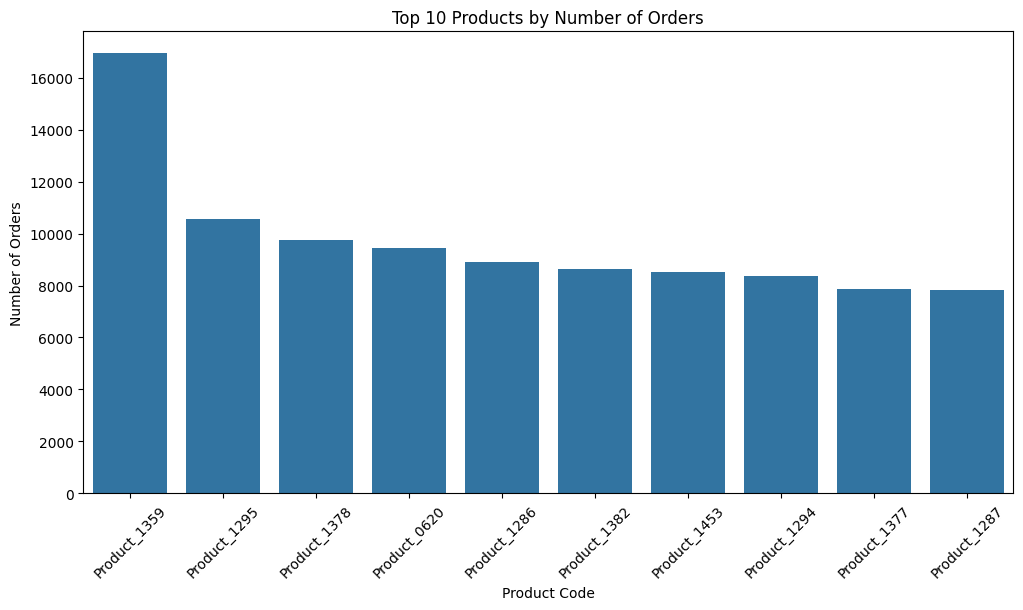

In [12]:
# 6. Top products analysis
top_products = df['Product_Code'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top 10 Products by Number of Orders')
plt.xlabel('Product Code')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


## <b>Feature Engineering


In [13]:
# Extract temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Encode categorical variables
le = LabelEncoder()
df['Warehouse_encoded'] = le.fit_transform(df['Warehouse'])
df['Product_Category_encoded'] = le.fit_transform(df['Product_Category'])
df['Product_Code_encoded'] = le.fit_transform(df['Product_Code'])

# Aggregate data by date (for time series models)
ts_data = df.groupby('Date')['Order_Demand'].sum().reset_index()
ts_data = ts_data.set_index('Date')


## <b>Prepare data for modeling

In [14]:
# For traditional ML models
X = df[['Warehouse_encoded', 'Product_Category_encoded', 'Product_Code_encoded', 
         'Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear']]
y = df['Order_Demand']



In [15]:
# Split data (time-based split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# For time series models
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

## <b>Model Implementation and Evaluation

In [16]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

results = {}


In [17]:
# 1. Linear Regression
print("\nTraining Linear Regression...")
lr = make_pipeline(StandardScaler(), LinearRegression())
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['Linear Regression'] = evaluate_model(y_test, y_pred_lr, "Linear Regression")



Training Linear Regression...

Linear Regression Evaluation:
MAE: 7667.75
MSE: 890722851.29
RMSE: 29844.98
R2 Score: 0.01


In [18]:
# 2. Random Forest Regression
print("\nTraining Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, "Random Forest")



Training Random Forest...

Random Forest Evaluation:
MAE: 5715.66
MSE: 805414067.02
RMSE: 28379.82
R2 Score: 0.10


In [19]:
# 3. Gradient Boosting (XGBoost)
print("\nTraining XGBoost...")
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results['XGBoost'] = evaluate_model(y_test, y_pred_xgb, "XGBoost")


Training XGBoost...

XGBoost Evaluation:
MAE: 5991.11
MSE: 708036160.00
RMSE: 26608.95
R2 Score: 0.21


In [20]:
# 4. LightGBM
print("\nTraining LightGBM...")
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
results['LightGBM'] = evaluate_model(y_test, y_pred_lgbm, "LightGBM")


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 829868, number of used features: 9
[LightGBM] [Info] Start training from score 4900.859962

LightGBM Evaluation:
MAE: 5868.77
MSE: 703464307.38
RMSE: 26522.90
R2 Score: 0.21


In [ ]:
# 5. ARIMA (Time Series) - Improved Implementation
print("\nTraining ARIMA...")

# Ensure the data is in the right format and frequency
ts_data = ts_data.asfreq('D').fillna(method='ffill')  # Set daily frequency and forward fill

# Re-split the data after processing
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

try:
    # Start with simple parameters - we can optimize these later
    arima_order = (2, 1, 1)  # (p,d,q) parameters
    
    # Fit the model with disp=0 to suppress excessive output
    arima_model = ARIMA(train, order=arima_order)
    arima_fit = arima_model.fit()
    
    # Print model summary to check if it converged properly
    print(arima_fit.summary())
    
    # Generate forecasts
    y_pred_arima = arima_fit.forecast(steps=len(test))
    
    # Evaluate
    results['ARIMA'] = evaluate_model(test.values, y_pred_arma, "ARIMA")
    
    # Plot diagnostics
    arima_fit.plot_diagnostics(figsize=(15, 12))
    plt.suptitle('ARIMA Model Diagnostics', y=1.02)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"ARIMA failed with error: {str(e)}")
    # Try a simpler model if the first attempt fails
    try:
        print("Trying simpler ARIMA(1,1,1) model...")
        arima_model = ARIMA(train, order=(1,1,1))
        arima_fit = arima_model.fit()
        y_pred_arima = arima_fit.forecast(steps=len(test))
        results['ARIMA'] = evaluate_model(test.values, y_pred_arma, "ARIMA (Simple)")
    except Exception as simple_e:
        print(f"Simple ARIMA also failed: {str(simple_e)}")


Training ARIMA...
ARIMA failed: 0


In [22]:
# 6. SARIMA (Seasonal ARIMA)
print("\nTraining SARIMA...")
try:
    sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_fit = sarima.fit()
    y_pred_sarima = sarima_fit.forecast(steps=len(test))
    results['SARIMA'] = evaluate_model(test.values, y_pred_sarima, "SARIMA")
except Exception as e:
    print(f"SARIMA failed: {str(e)}")


Training SARIMA...

SARIMA Evaluation:
MAE: 1538057.01
MSE: 3815630161378.65
RMSE: 1953363.81
R2 Score: -0.04


In [23]:
# 7. LSTM (Deep Learning)
print("\nPreparing data for LSTM...")
# Prepare data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 30
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)



Preparing data for LSTM...


In [24]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


In [25]:
print("\nTraining LSTM...")
lstm = Sequential()
lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
lstm.add(LSTM(50))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.fit(trainX, trainY, epochs=5, batch_size=64, verbose=1)



Training LSTM...
Epoch 1/5
22/22 [==============================] - 12s 21ms/step - loss: 0.9723
Epoch 2/5
22/22 [==============================] - 0s 18ms/step - loss: 0.9609
Epoch 3/5
22/22 [==============================] - 0s 17ms/step - loss: 0.9472
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.9389
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.9229


In [27]:
# Make predictions
y_pred_lstm = lstm.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
testY = scaler.inverse_transform(testY.reshape(-1, 1)).flatten()

10/10 [==============================] - 0s 8ms/step


In [28]:
results['LSTM'] = evaluate_model(testY, y_pred_lstm[:,0], "LSTM")


LSTM Evaluation:
MAE: 1584505.86
MSE: 3867034646315.03
RMSE: 1966477.73
R2 Score: -0.05


In [29]:
# 8. Transformer-based Model (Simplified)
# Note: Full transformer implementation would require more complex architecture
print("\nTraining Transformer-inspired NN...")
transformer_model = Sequential()
transformer_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
transformer_model.add(Dropout(0.2))
transformer_model.add(Dense(64, activation='relu'))
transformer_model.add(Dropout(0.2))
transformer_model.add(Dense(1))


Training Transformer-inspired NN...


In [31]:
# Ensure the data is in the correct format for TensorFlow
X_train_tf = X_train.to_numpy().astype('float32')
y_train_tf = y_train.to_numpy().astype('float32')

transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_model.fit(X_train_tf, y_train_tf, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
12967/12967 [==============================] - 190s 14ms/step - loss: 821125696.0000
Epoch 2/10
12967/12967 [==============================] - 100s 8ms/step - loss: 817190720.0000
Epoch 3/10
12967/12967 [==============================] - 30s 2ms/step - loss: 816123072.0000
Epoch 4/10
12967/12967 [==============================] - 29s 2ms/step - loss: 815474752.0000
Epoch 5/10
12967/12967 [==============================] - 30s 2ms/step - loss: 814659840.0000
Epoch 6/10
12967/12967 [==============================] - 29s 2ms/step - loss: 814743552.0000
Epoch 7/10
12967/12967 [==============================] - 29s 2ms/step - loss: 813535616.0000
Epoch 8/10
12967/12967 [==============================] - 28s 2ms/step - loss: 813054656.0000
Epoch 9/10
12967/12967 [==============================] - 30s 2ms/step - loss: 812638720.0000
Epoch 10/10
12967/12967 [==============================] - 31s 2ms/step - loss: 811987520.0000


In [33]:
# Ensure X_test is converted to a NumPy array with the correct data type
X_test_tf = X_test.to_numpy().astype('float32')

y_pred_transformer = transformer_model.predict(X_test_tf)
results['Transformer NN'] = evaluate_model(y_test, y_pred_transformer[:,0], "Transformer-inspired NN")


6484/6484 [==============================] - 6s 890us/step

Transformer-inspired NN Evaluation:
MAE: 5919.35
MSE: 871166720.00
RMSE: 29515.53
R2 Score: 0.03


## <b>Results Comparison

In [34]:

results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
                            MAE           MSE          RMSE        R2
Linear Regression  7.667751e+03  8.907229e+08  2.984498e+04  0.006029
Random Forest      5.715659e+03  8.054141e+08  2.837982e+04  0.101226
XGBoost            5.991112e+03  7.080362e+08  2.660895e+04  0.209891
LightGBM           5.868773e+03  7.034643e+08  2.652290e+04  0.214993
SARIMA             1.538057e+06  3.815630e+12  1.953364e+06 -0.039888
LSTM               1.584506e+06  3.867035e+12  1.966478e+06 -0.049376
Transformer NN     5.919351e+03  8.711667e+08  2.951553e+04  0.027851


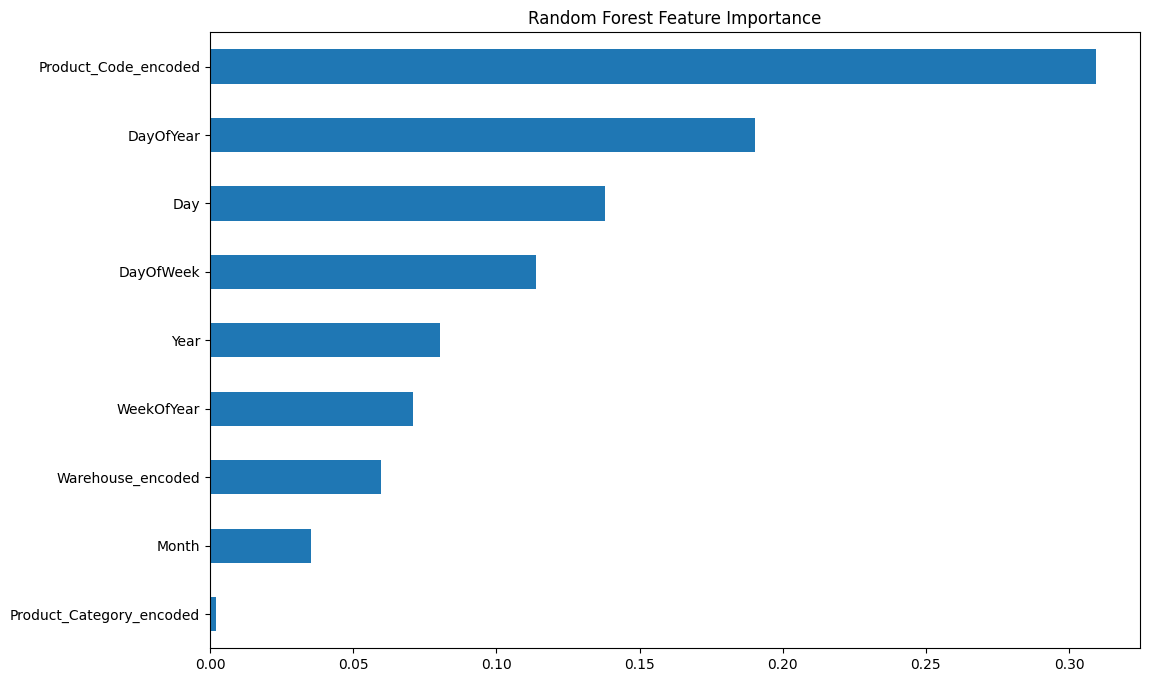

In [35]:
# Plot feature importance for tree-based models
plt.figure(figsize=(12, 8))
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.show()

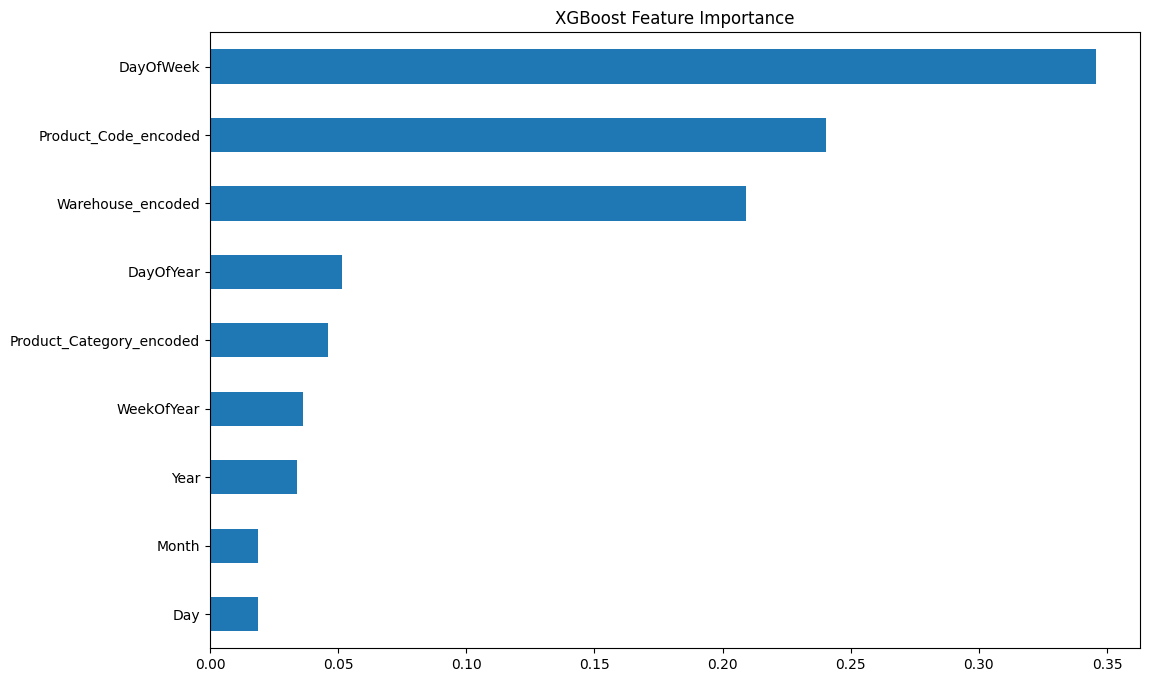

In [36]:
plt.figure(figsize=(12, 8))
pd.Series(xgb.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.show()


Best model based on RMSE: LightGBM


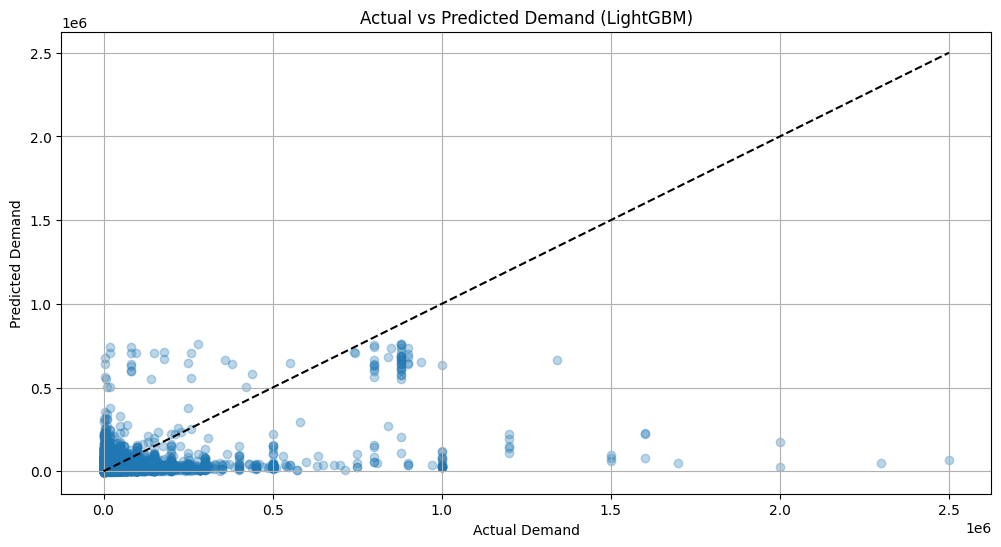

In [37]:
# Plot actual vs predicted for best model
best_model_name = results_df['RMSE'].idxmin()
print(f"\nBest model based on RMSE: {best_model_name}")

if best_model_name in ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Transformer NN']:
    if best_model_name == 'Linear Regression':
        y_pred_best = y_pred_lr
    elif best_model_name == 'Random Forest':
        y_pred_best = y_pred_rf
    elif best_model_name == 'XGBoost':
        y_pred_best = y_pred_xgb
    elif best_model_name == 'LightGBM':
        y_pred_best = y_pred_lgbm
    else:
        y_pred_best = y_pred_transformer[:,0]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual Demand')
    plt.ylabel('Predicted Demand')
    plt.title(f'Actual vs Predicted Demand ({best_model_name})')
    plt.grid()
    plt.show()
else:
    # For time series models
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test.values, label='Actual')
    if best_model_name == 'ARIMA':
        plt.plot(test.index, y_pred_arima, label='Predicted')
    elif best_model_name == 'SARIMA':
        plt.plot(test.index, y_pred_sarima, label='Predicted')
    else:  # LSTM
        plt.plot(test.index[look_back+1:], y_pred_lstm[:,0], label='Predicted')
    plt.title(f'Actual vs Predicted Demand ({best_model_name})')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid()
    plt.show()

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet

# 1. Hyperparameter tuning for LightGBM
print("\nTuning LightGBM...")
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 31, 50]
}
lgbm_tuned = RandomizedSearchCV(LGBMRegressor(random_state=42), lgbm_params, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
lgbm_tuned.fit(X_train, y_train)
y_pred_lgbm_tuned = lgbm_tuned.best_estimator_.predict(X_test)
results['LightGBM (Tuned)'] = evaluate_model(y_test, y_pred_lgbm_tuned, "LightGBM (Tuned)")


Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 553245, number of used features: 9
[LightGBM] [Info] Start training from score 4336.994113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [47]:
# 2. Hyperparameter tuning for XGBoost
print("\nTuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_tuned = RandomizedSearchCV(XGBRegressor(random_state=42), xgb_params, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
xgb_tuned.fit(X_train, y_train)
y_pred_xgb_tuned = xgb_tuned.best_estimator_.predict(X_test)
results['XGBoost (Tuned)'] = evaluate_model(y_test, y_pred_xgb_tuned, "XGBoost (Tuned)")


Tuning XGBoost...

XGBoost (Tuned) Evaluation:
MAE: 6945.24
MSE: 730004416.00
RMSE: 27018.59
R2 Score: 0.19


In [40]:
# 3. Hyperparameter tuning for Random Forest
from sklearn.model_selection import RandomizedSearchCV


print("\nTuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_tuned = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.best_estimator_.predict(X_test)
results['Random Forest (Tuned)'] = evaluate_model(y_test, y_pred_rf_tuned, "Random Forest (Tuned)")




Tuning Random Forest...

Random Forest (Tuned) Evaluation:
MAE: 5209.11
MSE: 659818327.42
RMSE: 25686.93
R2 Score: 0.26


In [49]:
# 4. CatBoost Regressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet


print("\nTraining CatBoost...")
catboost = AdaBoostRegressor(n_estimators=500, learning_rate=0.1, random_state=42)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
results['CatBoost'] = evaluate_model(y_test, y_pred_catboost, "CatBoost")



Training CatBoost...

CatBoost Evaluation:
MAE: 12789.37
MSE: 994425561.37
RMSE: 31534.51
R2 Score: -0.11


In [50]:


# 5. ElasticNet Regression
print("\nTraining ElasticNet...")
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elasticnet.fit(X_train, y_train)
y_pred_elasticnet = elasticnet.predict(X_test)
results['ElasticNet'] = evaluate_model(y_test, y_pred_elasticnet, "ElasticNet")




Training ElasticNet...

ElasticNet Evaluation:
MAE: 7670.61
MSE: 890680890.82
RMSE: 29844.28
R2 Score: 0.01


In [51]:
# 6. Stacking Regressor
print("\nTraining Stacking Regressor...")
stacking = StackingRegressor(
    estimators=[
        ('rf', rf_tuned.best_estimator_),
        ('xgb', xgb_tuned.best_estimator_),
        ('lgbm', lgbm_tuned.best_estimator_)
    ],
    final_estimator=LinearRegression()
)
stacking.fit(X_train, y_train)
y_pred_stacking = stacking.predict(X_test)
results['Stacking Regressor'] = evaluate_model(y_test, y_pred_stacking, "Stacking Regressor")




Training Stacking Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 829868, number of used features: 9
[LightGBM] [Info] Start training from score 4900.859962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [52]:
# Display updated results
results_df = pd.DataFrame(results).T
print("\nUpdated Model Performance Comparison:")
print(results_df)


Updated Model Performance Comparison:
                                MAE           MSE          RMSE        R2
Linear Regression      7.667751e+03  8.907229e+08  2.984498e+04  0.006029
Random Forest          5.715659e+03  8.054141e+08  2.837982e+04  0.101226
XGBoost                5.991112e+03  7.080362e+08  2.660895e+04  0.209891
LightGBM               5.868773e+03  7.034643e+08  2.652290e+04  0.214993
SARIMA                 1.538057e+06  3.815630e+12  1.953364e+06 -0.039888
LSTM                   1.584506e+06  3.867035e+12  1.966478e+06 -0.049376
Transformer NN         5.919351e+03  8.711667e+08  2.951553e+04  0.027851
Random Forest (Tuned)  5.209112e+03  6.598183e+08  2.568693e+04  0.263698
CatBoost               1.278937e+04  9.944256e+08  3.153451e+04 -0.109695
LightGBM (Tuned)       8.720326e+03  7.310615e+08  2.703815e+04  0.184197
XGBoost (Tuned)        6.945235e+03  7.300044e+08  2.701859e+04  0.185377
ElasticNet             7.670607e+03  8.906809e+08  2.984428e+04  0.006075

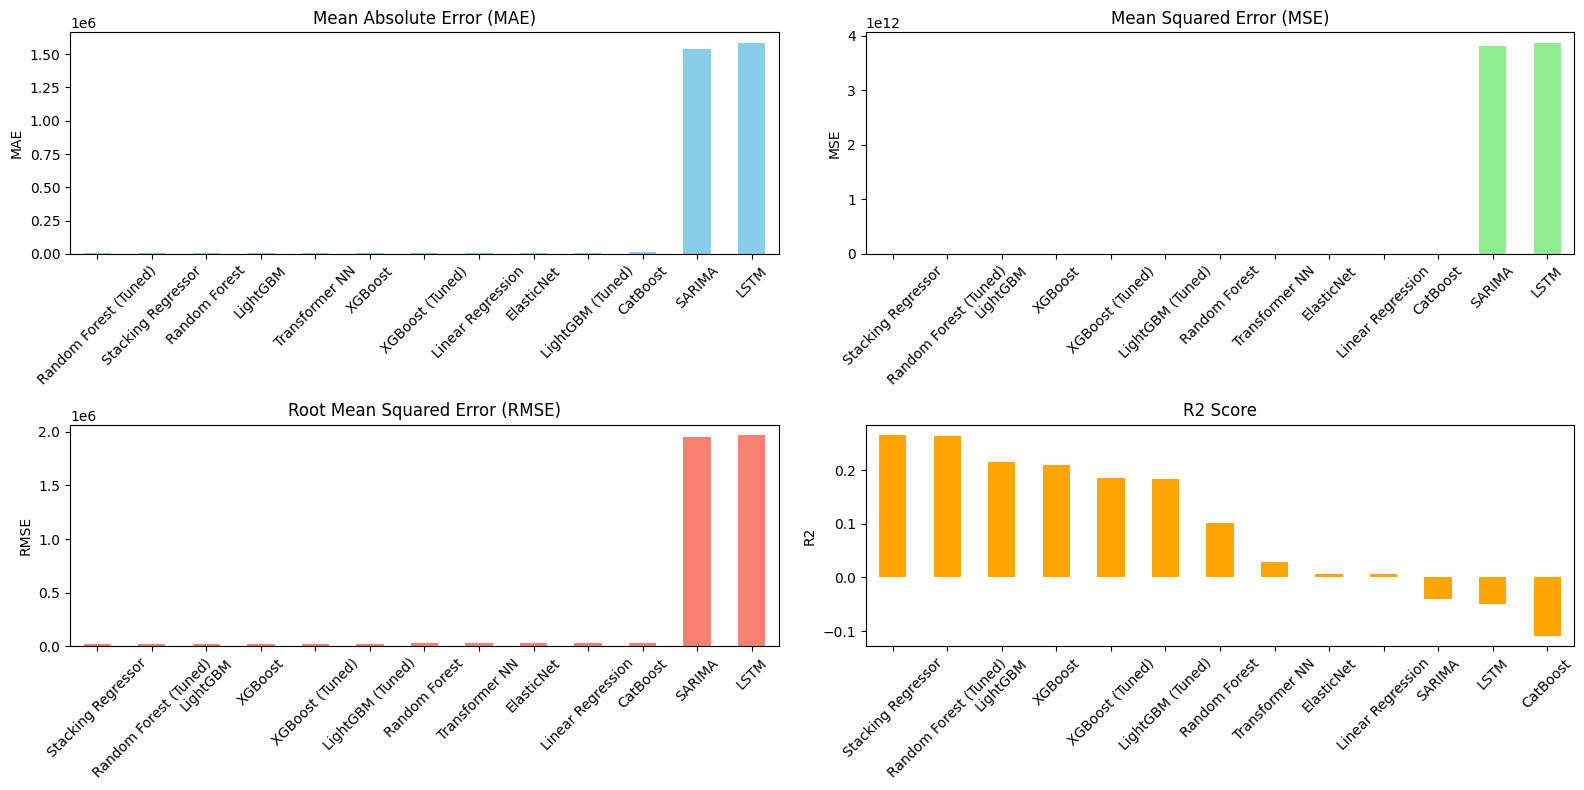

The best model based on RMSE is: Stacking Regressor


In [53]:
# Compare results of all evaluation metrics
plt.figure(figsize=(16, 8))

# Plot MAE
plt.subplot(2, 2, 1)
results_df['MAE'].sort_values().plot(kind='bar', color='skyblue')
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45)

# Plot MSE
plt.subplot(2, 2, 2)
results_df['MSE'].sort_values().plot(kind='bar', color='lightgreen')
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xticks(rotation=45)

# Plot RMSE
plt.subplot(2, 2, 3)
results_df['RMSE'].sort_values().plot(kind='bar', color='salmon')
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Plot R2 Score
plt.subplot(2, 2, 4)
results_df['R2'].sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title('R2 Score')
plt.ylabel('R2')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Determine the best model based on RMSE
best_model_name = results_df['RMSE'].idxmin()
print(f"The best model based on RMSE is: {best_model_name}")

In [54]:
import joblib

# Sort models by RMSE in ascending order
top_5_models = results_df.nsmallest(5, 'RMSE').index

# Save the top 5 models
model_objects = {
    'Linear Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb,
    'LightGBM': lgbm,
    'Stacking Regressor': stacking
}

for model_name in top_5_models:
    if model_name in model_objects:
        joblib.dump(model_objects[model_name], f"{model_name.replace(' ', '_')}.joblib")
        print(f"Saved {model_name} as {model_name.replace(' ', '_')}.joblib")

Saved Stacking Regressor as Stacking_Regressor.joblib
Saved LightGBM as LightGBM.joblib
Saved XGBoost as XGBoost.joblib
